In [1]:
#!pip install mlflow
#!pip install xgboost

In [2]:
import pycaret
from pycaret.classification import *
import pandas as pd
import xgboost
import os
import pickle
import pandas_profiling
from pandas_profiling import ProfileReport

In [3]:
import warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig(level=logging.ERROR)

In [4]:
# Set the working directory
directory_path = os.getcwd()

In [5]:
# Data Collection and Preparation
data_file = os.path.join(directory_path, 'data',  "data_makino.csv")

In [6]:
data_file

'C:\\downtime\\data\\data_makino.csv'

In [7]:
# Load the dataset
# data = pd.read_csv(data_file, nrows=2500)
data = pd.read_csv(data_file)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Date                             2500 non-null   object 
 1   Machine_ID                       2500 non-null   object 
 2   Assembly_Line_No                 2500 non-null   object 
 3   Hydraulic_Pressure(bar)          2490 non-null   float64
 4   Coolant_Pressure(bar)            2481 non-null   float64
 5   Air_System_Pressure(bar)         2483 non-null   float64
 6   Coolant_Temperature(°C)          2488 non-null   float64
 7   Hydraulic_Oil_Temperature(°C)    2484 non-null   float64
 8   Spindle_Bearing_Temperature(°C)  2493 non-null   float64
 9   Spindle_Vibration(µm)            2489 non-null   float64
 10  Tool_Vibration(µm)               2489 non-null   float64
 11  Spindle_Speed(RPM)               2494 non-null   float64
 12  Voltage(volts)      

In [9]:
# Adjusting the column names to make it easy to use
data.columns = data.columns.str.replace("(", "__")
data.columns = data.columns.str.replace(")", "")
data.columns = data.columns.str.replace("°C", "deg_cel")
data.columns = data.columns.str.replace("µ", "Micro")

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date                                  2500 non-null   object 
 1   Machine_ID                            2500 non-null   object 
 2   Assembly_Line_No                      2500 non-null   object 
 3   Hydraulic_Pressure__bar               2490 non-null   float64
 4   Coolant_Pressure__bar                 2481 non-null   float64
 5   Air_System_Pressure__bar              2483 non-null   float64
 6   Coolant_Temperature__deg_cel          2488 non-null   float64
 7   Hydraulic_Oil_Temperature__deg_cel    2484 non-null   float64
 8   Spindle_Bearing_Temperature__deg_cel  2493 non-null   float64
 9   Spindle_Vibration__Microm             2489 non-null   float64
 10  Tool_Vibration__Microm                2489 non-null   float64
 11  Spindle_Speed__RP

In [11]:
data.Downtime.value_counts()

Machine_Failure       1265
No_Machine_Failure    1235
Name: Downtime, dtype: int64

In [12]:
data.columns

Index(['Date', 'Machine_ID', 'Assembly_Line_No', 'Hydraulic_Pressure__bar',
       'Coolant_Pressure__bar', 'Air_System_Pressure__bar',
       'Coolant_Temperature__deg_cel', 'Hydraulic_Oil_Temperature__deg_cel',
       'Spindle_Bearing_Temperature__deg_cel', 'Spindle_Vibration__Microm',
       'Tool_Vibration__Microm', 'Spindle_Speed__RPM', 'Voltage__volts',
       'Torque__Nm', 'Cutting__kN', 'Downtime'],
      dtype='object')

In [13]:
# convert the 'date' column to datetime datatype
data['Date'] = pd.to_datetime(data['Date'])


In [14]:
data.columns

Index(['Date', 'Machine_ID', 'Assembly_Line_No', 'Hydraulic_Pressure__bar',
       'Coolant_Pressure__bar', 'Air_System_Pressure__bar',
       'Coolant_Temperature__deg_cel', 'Hydraulic_Oil_Temperature__deg_cel',
       'Spindle_Bearing_Temperature__deg_cel', 'Spindle_Vibration__Microm',
       'Tool_Vibration__Microm', 'Spindle_Speed__RPM', 'Voltage__volts',
       'Torque__Nm', 'Cutting__kN', 'Downtime'],
      dtype='object')

In [15]:
numeric_features = ['Hydraulic_Pressure__bar', 'Coolant_Pressure__bar', 'Air_System_Pressure__bar',
                    'Coolant_Temperature__deg_cel', 'Hydraulic_Oil_Temperature__deg_cel',
                    'Spindle_Bearing_Temperature__deg_cel', 'Spindle_Vibration__Microm',
                    'Tool_Vibration__Microm', 'Spindle_Speed__RPM', 'Voltage__volts', 'Torque__Nm', 'Cutting__kN']

In [16]:
categorical_features = ['Machine_ID', 'Assembly_Line_No']

In [17]:
# To get the unique values of all the columns
data.nunique(axis=0)

Date                                     164
Machine_ID                                 3
Assembly_Line_No                           3
Hydraulic_Pressure__bar                 1977
Coolant_Pressure__bar                   1628
Air_System_Pressure__bar                2472
Coolant_Temperature__deg_cel             275
Hydraulic_Oil_Temperature__deg_cel       209
Spindle_Bearing_Temperature__deg_cel     204
Spindle_Vibration__Microm               1144
Tool_Vibration__Microm                  2350
Spindle_Speed__RPM                      1180
Voltage__volts                           238
Torque__Nm                              1327
Cutting__kN                              170
Downtime                                   2
dtype: int64

In [18]:
# To get the unique values of the interested column
data.Machine_ID.unique()

array(['Makino-L1-Unit1-2013', 'Makino-L3-Unit1-2015',
       'Makino-L2-Unit1-2015'], dtype=object)

In [19]:
# To get the unique values of the interested column
data.Assembly_Line_No.unique()

array(['Shopfloor-L1', 'Shopfloor-L3', 'Shopfloor-L2'], dtype=object)

In [20]:
data['Downtime'] = data['Downtime'].replace(['Machine_Failure'], 1)
data['Downtime'] = data['Downtime'].replace(['No_Machine_Failure'], 0)

In [21]:
# To drop the column which is irrelevent to target variable
data.drop(['Date','Machine_ID', 'Assembly_Line_No'], axis=1, inplace=True)

In [22]:
data.shape

(2500, 13)

In [23]:
data.describe()

,Hydraulic_Pressure__bar,Coolant_Pressure__bar,Air_System_Pressure__bar,Coolant_Temperature__deg_cel,Hydraulic_Oil_Temperature__deg_cel,Spindle_Bearing_Temperature__deg_cel,Spindle_Vibration__Microm,Tool_Vibration__Microm,Spindle_Speed__RPM,Voltage__volts,Torque__Nm,Cutting__kN,Downtime
count,2490.000000,2481.000000,2483.000000,2488.000000,2484.000000,2493.000000,2489.000000,2489.000000,2494.000000,2494.000000,2479.000000,2493.000000,2500.000000
mean,101.409084,4.947058,6.499275,18.559887,47.618317,35.063698,1.009334,25.411975,20274.792302,348.996792,25.234968,2.782551,0.506000
std,30.289301,0.997357,0.407279,8.554480,3.768674,3.764823,0.342898,6.437142,3852.660056,45.376024,6.138564,0.616688,0.500064
min,-14.326454,0.325000,5.063480,4.100000,35.200000,22.600000,-0.461000,2.161000,0.000000,202.000000,0.000000,1.800000,0.000000
25%,76.355000,4.462464,6.217987,10.400000,45.100000,32.500000,0.777000,21.089000,17919.000000,319.000000,21.666115,2.250000,0.000000
50%,96.763486,4.939960,6.505191,21.200000,47.700000,35.100000,1.008000,25.455000,20137.500000,349.000000,24.647736,2.780000,1.000000
75%,126.415727,5.518401,6.780550,25.600000,50.100000,37.600000,1.236000,29.790000,22501.750000,380.000000,30.514008,3.270000,1.000000
max,191.000000,11.350000,7.973992,98.200000,61.400000,49.500000,2.000000,45.726000,27957.000000,479.000000,55.552400,3.930000,1.000000


In [24]:
data_stats = data.agg(['sum', 'min', 'max', 'mean', 'median', 'var', 'std', 'skew', 'kurt'])

In [25]:
data_stats

,Hydraulic_Pressure__bar,Coolant_Pressure__bar,Air_System_Pressure__bar,Coolant_Temperature__deg_cel,Hydraulic_Oil_Temperature__deg_cel,Spindle_Bearing_Temperature__deg_cel,Spindle_Vibration__Microm,Tool_Vibration__Microm,Spindle_Speed__RPM,Voltage__volts,Torque__Nm,Cutting__kN,Downtime
sum,252508.618606,12273.652073,16137.698822,46177.000000,118283.900000,87413.800000,2512.233000,63250.406000,5.056533e+07,870398.000000,62557.485003,6936.900000,1265.000000
min,-14.326454,0.325000,5.063480,4.100000,35.200000,22.600000,-0.461000,2.161000,0.000000e+00,202.000000,0.000000,1.800000,0.000000
max,191.000000,11.350000,7.973992,98.200000,61.400000,49.500000,2.000000,45.726000,2.795700e+04,479.000000,55.552400,3.930000,1.000000
mean,101.409084,4.947058,6.499275,18.559887,47.618317,35.063698,1.009334,25.411975,2.027479e+04,348.996792,25.234968,2.782551,0.506000
median,96.763486,4.939960,6.505191,21.200000,47.700000,35.100000,1.008000,25.455000,2.013750e+04,349.000000,24.647736,2.780000,1.000000
var,917.441733,0.994721,0.165877,73.179122,14.202906,14.173894,0.117579,41.436795,1.484299e+07,2058.983544,37.681962,0.380304,0.250064
std,30.289301,0.997357,0.407279,8.554480,3.768674,3.764823,0.342898,6.437142,3.852660e+03,45.376024,6.138564,0.616688,0.500064
skew,0.197076,0.147081,-0.052899,0.108301,-0.002291,-0.035942,0.001532,-0.061005,-1.724752e-01,-0.028658,0.030578,0.113963,-0.024016
kurt,-0.920292,1.169455,-0.001578,1.564639,0.038164,-0.043862,-0.018718,0.006451,1.344769e+00,-0.090328,-0.465628,-1.087171,-2.001025


In [26]:
# Statitics information exported to HTML file
stats_file = os.path.join(directory_path, 'metrics',  "makino_stats.html")
data_stats.to_html(stats_file)

In [27]:
data_mode = data.agg(['mode'])

In [28]:
data_mode

,Hydraulic_Pressure__bar,Coolant_Pressure__bar,Air_System_Pressure__bar,Coolant_Temperature__deg_cel,Hydraulic_Oil_Temperature__deg_cel,Spindle_Bearing_Temperature__deg_cel,Spindle_Vibration__Microm,Tool_Vibration__Microm,Spindle_Speed__RPM,Voltage__volts,Torque__Nm,Cutting__kN,Downtime
,mode,mode,mode,mode,mode,mode,mode,mode,mode,mode,mode,mode,mode
0,88.279134,4.566854,5.628717,26.4,47.5,34.6,1.231,26.736,17726.0,337.0,35.580334,3.55,1.0
1,89.458747,4.842521,5.928643,NaN,48.0,NaN,NaN,30.585,NaN,NaN,NaN,3.67,NaN
2,90.458747,5.567857,5.955235,NaN,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,5.918357,6.011483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,6.560332,6.167549,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,6.839413,6.430073,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,6.863944,6.668245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,6.893182,6.753560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,6.836188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# Statitics (Mode) information exported to HTML file
mode_file = os.path.join(directory_path, 'metrics',  "makino_stats_mode.html")
data_mode.to_html(mode_file)

# Data insights

we can observe the following insights related to machine downtime from the above statistics:

The maximum downtime recorded in the dataset is 1,265 minutes, which is significantly higher than the median downtime of 1 minute. This indicates that there are some instances where the machine has experienced prolonged downtime, which needs to be addressed.

The minimum value of the hydraulic pressure is negative, which is not physically possible. This suggests that there may be some data entry errors in the dataset, which need to be corrected.

The average hydraulic pressure is 101.41 bar, with a standard deviation of 30.29 bar. The maximum value recorded for hydraulic pressure is 191 bar, which is quite high compared to the mean value. This could indicate that the machine is operating under stress, which may lead to downtime.

The average coolant temperature is 18.56°C, with a standard deviation of 8.55°C. The maximum coolant temperature recorded is 98.2°C, which is significantly higher than the mean value. This could indicate that the machine is experiencing overheating, which may lead to downtime.

The spindle speed ranges from 0 to 27,957 RPM, with an average of 20,274 RPM. The standard deviation is quite high at 3,852.66 RPM, indicating that there is a significant variation in spindle speed. This could be an indication of machine instability, which may lead to downtime.

The voltage ranges from 202 to 479 volts, with an average of 349 volts. The standard deviation is 45.38 volts, which indicates that there is some variation in voltage. Fluctuations in voltage can affect machine performance and lead to downtime.

The torque ranges from 0 to 55.55 Nm, with an average of 25.23 Nm. The standard deviation is 6.14 Nm, indicating some variation in torque. Fluctuations in torque can affect machine performance and lead to downtime.

Overall, the insights suggest that machine downtime is affected by various factors such as hydraulic pressure, coolant temperature, spindle speed, voltage, and torque. By monitoring and optimizing these factors, it may be possible to reduce machine downtime and improve productivity.

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Hydraulic_Pressure__bar               2490 non-null   float64
 1   Coolant_Pressure__bar                 2481 non-null   float64
 2   Air_System_Pressure__bar              2483 non-null   float64
 3   Coolant_Temperature__deg_cel          2488 non-null   float64
 4   Hydraulic_Oil_Temperature__deg_cel    2484 non-null   float64
 5   Spindle_Bearing_Temperature__deg_cel  2493 non-null   float64
 6   Spindle_Vibration__Microm             2489 non-null   float64
 7   Tool_Vibration__Microm                2489 non-null   float64
 8   Spindle_Speed__RPM                    2494 non-null   float64
 9   Voltage__volts                        2494 non-null   float64
 10  Torque__Nm                            2479 non-null   float64
 11  Cutting__kN      

In [31]:
# Setup the pycaret environment
classif3 = pycaret.classification.setup(data = data, 
                             # data_func = None, 
                             target = 'Downtime', 
                             # index = True, 
                             train_size = 0.7,
                             test_data = None, 
                             ordinal_features = None,         
                             numeric_features = None, 
                             # categorical_features = None, 
                             # date_features = None,
                             # text_features = None, 
                             # ignore_features = None, 
                             # keep_features = None, 
                             preprocess = True, 
                             # create_date_columns = ["day", "month", "year"],
                             imputation_type = 'simple', 
                             numeric_imputation = 'mean', 
                             categorical_imputation = 'mode', 
                             # iterative_imputation_iters = 5, 
                             # numeric_iterative_imputer = 'lightgbm', 
                             # categorical_iterative_imputer = 'lightgbm', 
                             # text_features_method = 'tf-idf', 
                             # max_encoding_ohe = 25, 
                             # encoding_method = None, 
                             # rare_to_value = None, 
                             # rare_value = False, 
                             # polynomial_degree = 2, 
                             # low_variance_threshold = None, 
                             # group_features = None, 
                             # group_names = None, 
                             # drop_groups = False, 
                             remove_multicollinearity = True, 
                             multicollinearity_threshold = 0.9, 
                             # bin_numeric_features = None, 
                             remove_outliers = True, 
                             # outliers_method = 'iforest', 
                             # outliers_threshold = 0.05, 
                             # fix_imbalance = False, 
                             # fix_imbalance_method = 'SMOTE', 
                             transformation = True, 
                             transformation_method = 'yeo-johnson', 
                             normalize = True, 
                             normalize_method = 'zscore', 
                             # pca  = True, 
                             # pca_method = 'linear', 
                             # pca_components = None, 
                             # feature_selection = False, 
                             # feature_selection_method = 'classic', 
                             # feature_selection_estimator = 'lightgbm', 
                             # n_features_to_select = 0.2, 
                             # custom_pipeline = None, 
                             # custom_pipeline_position = -1, 
                             # data_split_shuffle = True,
                             # data_split_stratify = True, 
                             # fold_strategy = 'stratifiedkfold', 
                             # fold = 10, 
                             # fold_shuffle = False, 
                             # fold_groups = None, 
                             n_jobs = -1, 
                             # use_gpu = Flase, 
                             # html = False, 
                             # session_id = None, 
                             # system_log = True, 
                             log_experiment = True, 
                             experiment_name = "Exp_downtime_01", 
                             # experiment_custom_tags = None, 
                             # log_plots = True, 
                             log_profile = True, 
                             # log_data = True, 
                             # verbose = False, 
                             # memory = True, 
                             profile = True, 
                             # profile_kwargs = None,
                             silent = True
                            )

,Description,Value
0,session_id,1820
1,Target,Downtime
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(2500, 13)"
5,Missing Values,True
6,Numeric Features,12
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='Downtime',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='most frequent',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_str...
                ('dummy', Dummify(target='Downtime')),
                ('fix_perfect', Remove_100(target='Downtime')),
                ('clean_names', Clean_Colum_Names()),


In [32]:
'''
classification_downtime = pycaret.classification.setup(data = data, target = 'Downtime', 
            train_size = 0.7, test_data = None, 
            ordinal_features = None, numeric_features = None, preprocess = True, 
            imputation_type = 'simple', numeric_imputation = 'mean', 
            categorical_imputation = 'mode', remove_multicollinearity = True, 
            multicollinearity_threshold = 0.9, remove_outliers = True, transformation = True, 
            transformation_method = 'yeo-johnson', normalize = True, normalize_method = 'zscore', 
            n_jobs = -1, log_experiment = True, experiment_name = "Exp_downtime_01", 
            log_profile = True, profile = True, silent = True)
'''


'\nclassification_downtime = pycaret.classification.setup(data = data, target = \'Downtime\', \n            train_size = 0.7, test_data = None, \n            ordinal_features = None, numeric_features = None, preprocess = True, \n            imputation_type = \'simple\', numeric_imputation = \'mean\', \n            categorical_imputation = \'mode\', remove_multicollinearity = True, \n            multicollinearity_threshold = 0.9, remove_outliers = True, transformation = True, \n            transformation_method = \'yeo-johnson\', normalize = True, normalize_method = \'zscore\', \n            n_jobs = -1, log_experiment = True, experiment_name = "Exp_downtime_01", \n            log_profile = True, profile = True, silent = True)\n'

In [33]:
### 1. ANN model

# Create ANN model
ann = create_model('mlp')
# ann = create_model('mlp', hidden_layers=[32, 16], learning_rate=0.01, activation='relu')
# ReLU (rectified linear unit) and tanh (hyperbolic tangent) activation functions are widely used.
# The 'tanh' is computationally intensive compared to 'relu'.
# Therefore, this project may require to predict real-time failures in advance. Thus 'relu' is used here.

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9760,0.9989,0.9767,0.9767,0.9767,0.9521,0.9521
1,0.9639,0.9959,0.9651,0.9651,0.9651,0.9276,0.9276
2,0.9699,0.9922,0.9651,0.9765,0.9708,0.9397,0.9398
3,0.9759,0.9951,0.9765,0.9765,0.9765,0.9518,0.9518
4,0.9518,0.9900,0.9529,0.9529,0.9529,0.9036,0.9036
5,0.9518,0.9923,0.9176,0.9873,0.9512,0.9037,0.9061
6,0.9458,0.9894,0.9765,0.9222,0.9486,0.8913,0.8930
7,0.9639,0.9948,0.9529,0.9759,0.9643,0.9277,0.9280
8,0.9518,0.9962,0.9765,0.9326,0.9540,0.9034,0.9045
9,0.9458,0.9948,0.9529,0.9419,0.9474,0.8915,0.8915


INFO:logs:create_model_container: 1
INFO:logs:master_model_container: 1
INFO:logs:display_container: 2
INFO:logs:MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1820, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
INFO:logs:create_model() succesfully completed......................................


In [34]:
### 2. Extreme Gradient Boosting model

# Create xgboost model
xgboost = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,0.9880,1.0000,1.0000,0.9770,0.9884,0.9759,0.9762
4,0.9940,1.0000,1.0000,0.9884,0.9942,0.9879,0.9880
5,0.9880,0.9978,0.9765,1.0000,0.9881,0.9759,0.9762
6,0.9940,1.0000,1.0000,0.9884,0.9942,0.9879,0.9880
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,0.9880,0.9999,1.0000,0.9770,0.9884,0.9759,0.9762
9,0.9940,0.9999,0.9882,1.0000,0.9941,0.9879,0.9880


INFO:logs:create_model_container: 2
INFO:logs:master_model_container: 2
INFO:logs:display_container: 3
INFO:logs:XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              objective='binary:logistic', predictor=None, ...)
INFO:logs:create_model() succesfully completed......................................


In [35]:
### 3. Decision Tree Classifier model

# Create dt model
dt = create_model('dt')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9701,0.9702,0.9651,0.9765,0.9708,0.9401,0.9402
1,0.9639,0.9638,0.9651,0.9651,0.9651,0.9276,0.9276
2,0.9699,0.9692,0.9884,0.9551,0.9714,0.9396,0.9402
3,0.9880,0.9879,0.9882,0.9882,0.9882,0.9759,0.9759
4,0.9578,0.9580,0.9529,0.9643,0.9586,0.9156,0.9157
5,0.9398,0.9403,0.9176,0.9630,0.9398,0.8796,0.8806
6,0.9759,0.9759,0.9765,0.9765,0.9765,0.9518,0.9518
7,0.9880,0.9879,0.9882,0.9882,0.9882,0.9759,0.9759
8,0.9819,0.9818,0.9882,0.9767,0.9825,0.9638,0.9639
9,0.9759,0.9759,0.9765,0.9765,0.9765,0.9518,0.9518


INFO:logs:create_model_container: 3
INFO:logs:master_model_container: 3
INFO:logs:display_container: 4
INFO:logs:DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1820, splitter='best')
INFO:logs:create_model() succesfully completed......................................


In [36]:
### 4. Gradient Boosting Classifier model

# Create gbc model
gbc = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,0.9940,1.0000,0.9884,1.0000,0.9942,0.9879,0.9880
3,0.9819,0.9999,1.0000,0.9659,0.9827,0.9638,0.9644
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,0.9880,0.9971,0.9765,1.0000,0.9881,0.9759,0.9762
6,0.9940,0.9997,0.9882,1.0000,0.9941,0.9879,0.9880
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,0.9880,0.9936,1.0000,0.9770,0.9884,0.9759,0.9762
9,0.9880,0.9943,0.9765,1.0000,0.9881,0.9759,0.9762


INFO:logs:create_model_container: 4
INFO:logs:master_model_container: 4
INFO:logs:display_container: 5
INFO:logs:GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1820, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
INFO:logs:create_model() succesfully completed......................................


In [37]:
### 5. Light Gradient Boosting Machine model

# Create lightgbm model
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,0.9940,1.0000,0.9884,1.0000,0.9942,0.9879,0.9880
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,0.9940,0.9999,1.0000,0.9884,0.9942,0.9879,0.9880
4,0.9940,1.0000,1.0000,0.9884,0.9942,0.9879,0.9880
5,0.9759,0.9974,0.9765,0.9765,0.9765,0.9518,0.9518
6,0.9940,0.9999,1.0000,0.9884,0.9942,0.9879,0.9880
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,0.9880,0.9903,1.0000,0.9770,0.9884,0.9759,0.9762
9,0.9880,0.9983,0.9765,1.0000,0.9881,0.9759,0.9762


INFO:logs:create_model_container: 5
INFO:logs:master_model_container: 5
INFO:logs:display_container: 6
INFO:logs:LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=1820, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:create_model() succesfully completed......................................


In [38]:
### 6. Extra Trees Classifier model

# Create et model
et = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,0.9819,0.9994,0.9767,0.9882,0.9825,0.9638,0.9639
2,0.9940,0.9999,0.9884,1.0000,0.9942,0.9879,0.9880
3,0.9940,0.9999,1.0000,0.9884,0.9942,0.9879,0.9880
4,0.9880,0.9989,0.9882,0.9882,0.9882,0.9759,0.9759
5,0.9819,0.9983,0.9647,1.0000,0.9820,0.9639,0.9645
6,0.9880,0.9994,0.9882,0.9882,0.9882,0.9759,0.9759
7,0.9940,0.9997,1.0000,0.9884,0.9942,0.9879,0.9880
8,0.9819,0.9997,0.9882,0.9767,0.9825,0.9638,0.9639
9,0.9940,0.9983,0.9882,1.0000,0.9941,0.9879,0.9880


INFO:logs:create_model_container: 6
INFO:logs:master_model_container: 6
INFO:logs:display_container: 7
INFO:logs:ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=1820, verbose=0,
                     warm_start=False)
INFO:logs:create_model() succesfully completed......................................


In [39]:
### 7. Random Forest Classifier model

# Create rf model
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9880,0.9999,0.9767,1.0000,0.9882,0.9760,0.9763
1,0.9880,0.9997,0.9767,1.0000,0.9882,0.9759,0.9762
2,0.9880,0.9996,0.9884,0.9884,0.9884,0.9759,0.9759
3,0.9880,0.9996,1.0000,0.9770,0.9884,0.9759,0.9762
4,0.9940,0.9997,1.0000,0.9884,0.9942,0.9879,0.9880
5,0.9819,0.9970,0.9647,1.0000,0.9820,0.9639,0.9645
6,0.9819,0.9996,0.9882,0.9767,0.9825,0.9638,0.9639
7,0.9940,0.9999,0.9882,1.0000,0.9941,0.9879,0.9880
8,0.9940,0.9997,1.0000,0.9884,0.9942,0.9879,0.9880
9,0.9819,0.9993,0.9647,1.0000,0.9820,0.9639,0.9645


INFO:logs:create_model_container: 7
INFO:logs:master_model_container: 7
INFO:logs:display_container: 8
INFO:logs:RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1820, verbose=0,
                       warm_start=False)
INFO:logs:create_model() succesfully completed......................................


In [40]:
### 8. K Neighbors Classifier model

# Create knn model
knn = create_model('knn')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8802,0.9305,0.9070,0.8667,0.8864,0.7599,0.7608
1,0.8614,0.9420,0.8605,0.8706,0.8655,0.7227,0.7227
2,0.8795,0.9152,0.8953,0.8750,0.8851,0.7585,0.7587
3,0.9036,0.9527,0.9176,0.8966,0.9070,0.8070,0.8072
4,0.8795,0.9540,0.9059,0.8652,0.8851,0.7586,0.7595
5,0.8735,0.9229,0.8235,0.9211,0.8696,0.7475,0.7519
6,0.8795,0.9453,0.8588,0.9012,0.8795,0.7592,0.7601
7,0.8855,0.9641,0.8941,0.8837,0.8889,0.7709,0.7709
8,0.9036,0.9609,0.9294,0.8876,0.9080,0.8069,0.8078
9,0.8614,0.9287,0.8471,0.8780,0.8623,0.7230,0.7234


INFO:logs:create_model_container: 8
INFO:logs:master_model_container: 8
INFO:logs:display_container: 9
INFO:logs:KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')
INFO:logs:create_model() succesfully completed......................................


In [41]:
### 8. Logistic Regression model

# Create lr model
lr = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8383,0.9187,0.8488,0.8391,0.8439,0.6762,0.6763
1,0.8494,0.9342,0.8605,0.8506,0.8555,0.6983,0.6983
2,0.8313,0.9113,0.8837,0.8085,0.8444,0.6610,0.6641
3,0.8494,0.9102,0.8706,0.8409,0.8555,0.6984,0.6988
4,0.8916,0.9461,0.9059,0.8851,0.8953,0.7829,0.7831
5,0.8554,0.9163,0.7882,0.9178,0.8481,0.7117,0.7192
6,0.8253,0.9165,0.8118,0.8415,0.8263,0.6507,0.6511
7,0.8554,0.9219,0.8824,0.8427,0.8621,0.7103,0.7112
8,0.8855,0.9529,0.9294,0.8587,0.8927,0.7705,0.7733
9,0.8554,0.9309,0.8471,0.8675,0.8571,0.7108,0.7110


INFO:logs:create_model_container: 9
INFO:logs:master_model_container: 9
INFO:logs:display_container: 10
INFO:logs:LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1820, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
INFO:logs:create_model() succesfully completed......................................


In [42]:
### 10. Ridge Classifier model

# Create ridge model
ridge = create_model('ridge')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8323,0.0000,0.8372,0.8372,0.8372,0.6644,0.6644
1,0.8434,0.0000,0.8605,0.8409,0.8506,0.6861,0.6863
2,0.8373,0.0000,0.8721,0.8242,0.8475,0.6736,0.6748
3,0.8614,0.0000,0.8588,0.8690,0.8639,0.7228,0.7229
4,0.8795,0.0000,0.8824,0.8824,0.8824,0.7589,0.7589
5,0.8494,0.0000,0.7765,0.9167,0.8408,0.6998,0.7084
6,0.8253,0.0000,0.8118,0.8415,0.8263,0.6507,0.6511
7,0.8614,0.0000,0.8824,0.8523,0.8671,0.7225,0.7230
8,0.8976,0.0000,0.9294,0.8778,0.9029,0.7948,0.7962
9,0.8313,0.0000,0.8118,0.8519,0.8313,0.6628,0.6636


INFO:logs:create_model_container: 10
INFO:logs:master_model_container: 10
INFO:logs:display_container: 11
INFO:logs:RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=1820,
                solver='auto', tol=0.001)
INFO:logs:create_model() succesfully completed......................................


In [43]:
### 11. SVM - Linear Kernel model

# Create svm model
svm = create_model('svm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8443,0.0000,0.8372,0.8571,0.8471,0.6886,0.6888
1,0.8253,0.0000,0.8023,0.8519,0.8263,0.6509,0.6521
2,0.8253,0.0000,0.8953,0.7938,0.8415,0.6485,0.6543
3,0.8373,0.0000,0.8588,0.8295,0.8439,0.6742,0.6747
4,0.8373,0.0000,0.8118,0.8625,0.8364,0.6750,0.6762
5,0.8253,0.0000,0.7647,0.8784,0.8176,0.6515,0.6573
6,0.7952,0.0000,0.7412,0.8400,0.7875,0.5913,0.5956
7,0.8072,0.0000,0.8000,0.8193,0.8095,0.6145,0.6146
8,0.8735,0.0000,0.9059,0.8556,0.8800,0.7465,0.7478
9,0.8614,0.0000,0.8588,0.8690,0.8639,0.7228,0.7229


INFO:logs:create_model_container: 11
INFO:logs:master_model_container: 11
INFO:logs:display_container: 12
INFO:logs:SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=1820, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
INFO:logs:create_model() succesfully completed......................................


In [44]:
### 12. Naive Bayes model

# Create nb model
nb = create_model('nb')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8383,0.9255,0.8605,0.8315,0.8457,0.6760,0.6764
1,0.8313,0.9347,0.8605,0.8222,0.8409,0.6616,0.6624
2,0.8313,0.9163,0.8721,0.8152,0.8427,0.6613,0.6631
3,0.8554,0.9104,0.8706,0.8506,0.8605,0.7105,0.7107
4,0.8735,0.9495,0.8706,0.8810,0.8757,0.7469,0.7470
5,0.8614,0.9174,0.7882,0.9306,0.8535,0.7238,0.7328
6,0.8253,0.9203,0.7882,0.8590,0.8221,0.6511,0.6534
7,0.8494,0.9278,0.8706,0.8409,0.8555,0.6984,0.6988
8,0.9157,0.9624,0.9412,0.8989,0.9195,0.8310,0.8320
9,0.8614,0.9348,0.8353,0.8875,0.8606,0.7231,0.7244


INFO:logs:create_model_container: 12
INFO:logs:master_model_container: 12
INFO:logs:display_container: 13
INFO:logs:GaussianNB(priors=None, var_smoothing=1e-09)
INFO:logs:create_model() succesfully completed......................................


In [45]:
# Compare models and return a pycaret table of best models with their evaluation metrics ordered by its accuracy.
# best_model = compare_models(compare_models(include = [ann, ['xgboost'], lightgbm, dt, svm, rf]))

best_model = compare_models(include=['mlp', 'lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'ridge', 'rf', 'qda', 'ada', 'gbc', 'lda', 'et', 'xgboost', 'lightgbm'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9946,0.9998,0.9965,0.9931,0.9947,0.9891,0.9893,0.0580
gbc,Gradient Boosting Classifier,0.9934,0.9985,0.9930,0.9943,0.9935,0.9867,0.9869,0.1110
lightgbm,Light Gradient Boosting Machine,0.9928,0.9986,0.9941,0.9919,0.9930,0.9855,0.9856,0.0470
ada,Ada Boost Classifier,0.9928,0.9984,0.9942,0.9919,0.9930,0.9855,0.9856,0.0470
et,Extra Trees Classifier,0.9898,0.9993,0.9883,0.9918,0.9900,0.9795,0.9796,0.0880
rf,Random Forest Classifier,0.9880,0.9994,0.9848,0.9919,0.9882,0.9759,0.9761,0.1150
dt,Decision Tree Classifier,0.9711,0.9711,0.9707,0.9730,0.9718,0.9422,0.9424,0.0070
mlp,MLP Classifier,0.9597,0.9939,0.9613,0.9608,0.9608,0.9192,0.9198,1.1750
gpc,Gaussian Process Classifier,0.8934,0.9443,0.8944,0.8992,0.8960,0.7867,0.7882,2.7330
knn,K Neighbors Classifier,0.8808,0.9416,0.8839,0.8846,0.8837,0.7614,0.7623,0.0190


INFO:logs:create_model_container: 29
INFO:logs:master_model_container: 29
INFO:logs:display_container: 14
INFO:logs:XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              objective='binary:logistic', predictor=None, ...)
INFO:logs:compare_models() succesfully completed......................................


In [46]:
best_models_metrics = pull()

In [47]:
best_models_metrics

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9946,0.9998,0.9965,0.9931,0.9947,0.9891,0.9893,0.058
gbc,Gradient Boosting Classifier,0.9934,0.9985,0.9930,0.9943,0.9935,0.9867,0.9869,0.111
lightgbm,Light Gradient Boosting Machine,0.9928,0.9986,0.9941,0.9919,0.9930,0.9855,0.9856,0.047
ada,Ada Boost Classifier,0.9928,0.9984,0.9942,0.9919,0.9930,0.9855,0.9856,0.047
et,Extra Trees Classifier,0.9898,0.9993,0.9883,0.9918,0.9900,0.9795,0.9796,0.088
rf,Random Forest Classifier,0.9880,0.9994,0.9848,0.9919,0.9882,0.9759,0.9761,0.115
dt,Decision Tree Classifier,0.9711,0.9711,0.9707,0.9730,0.9718,0.9422,0.9424,0.007
mlp,MLP Classifier,0.9597,0.9939,0.9613,0.9608,0.9608,0.9192,0.9198,1.175
gpc,Gaussian Process Classifier,0.8934,0.9443,0.8944,0.8992,0.8960,0.7867,0.7882,2.733
knn,K Neighbors Classifier,0.8808,0.9416,0.8839,0.8846,0.8837,0.7614,0.7623,0.019


In [49]:
# Train the best_model model from the list of models computed earlier.
tuned_best = tune_model(estimator = best_model, optimize = 'F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,0.9940,1.0000,1.0000,0.9884,0.9942,0.9879,0.9880
4,0.9940,1.0000,1.0000,0.9884,0.9942,0.9879,0.9880
5,0.9819,0.9990,0.9765,0.9881,0.9822,0.9638,0.9639
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,0.9880,1.0000,1.0000,0.9770,0.9884,0.9759,0.9762
9,0.9880,0.9994,0.9882,0.9882,0.9882,0.9759,0.9759


INFO:logs:create_model_container: 30
INFO:logs:master_model_container: 30
INFO:logs:display_container: 15
INFO:logs:XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=90, n_jobs=-1, num_parallel_tree=None,
              objective='binary:logistic', predictor=None, ...)
INFO:logs:tune_model() succesfully completed......................................


INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=90, n_jobs=-1, num_parallel_tree=None,
              objective='binary:logistic', predictor=None, ...), fold=None, fit_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

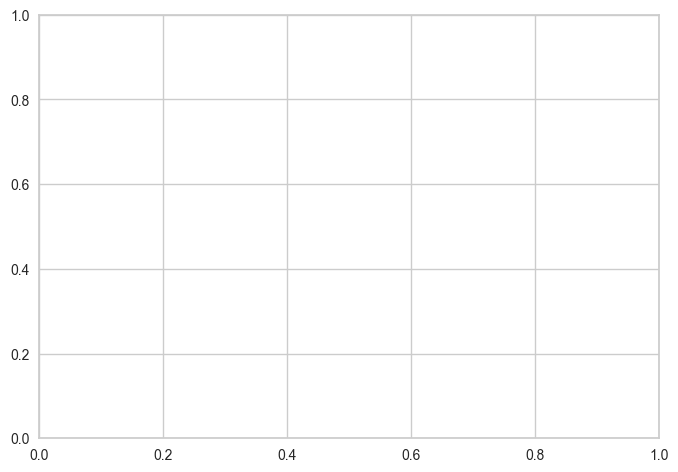

In [50]:
# Evaluate tuned_best model
evaluate_model(tuned_best)

In [51]:
predicted_downtime = predict_model(tuned_best)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=90, n_jobs=-1, num_parallel_tree=None,
              objective='binary:logistic', predictor=None, ...), probability_threshold=None, encoded_labels=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None)
INFO:logs:Checking exceptions


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9840,0.9975,0.9725,0.9944,0.9833,0.9680,0.9682


In [52]:
# Deploy model
final_best = finalize_model(estimator = tuned_best)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=90, n_jobs=-1, num_parallel_tree=None,
              objective='binary:logistic', predictor=None, ...), fit_kwargs=None, groups=None, model_only=True, display=None)
INFO:logs:Finalizing XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsampl

In [53]:
print(final_best)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=90, n_jobs=-1, num_parallel_tree=None,
              objective='binary:logistic', predictor=None, ...)


# autoEDA report using pandas-profiling

In [54]:
# save the profiling report
design_report = ProfileReport(data)

In [55]:
# Save the profiling report (autoEDA file) to local drive.
autoEDA_file = os.path.join(directory_path, 'models', 'downtime_autoEDA.html')
design_report.to_file(output_file = autoEDA_file)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# model building, training, and evaluation

# Saving the trained models

In [56]:
# Saving the best model in .sav file format.
autoML_best_sav = os.path.join(directory_path, 'models', 'autoML_best_sav.sav')
pickle.dump(final_best, open(autoML_best_sav, 'wb')) # wb = writing binary

In [57]:
# 0). Saving the best model in .pkl file format.
autoML_best = os.path.join(directory_path, 'models', 'downtime_best.pkl')
pickle.dump(final_best, open(autoML_best, "wb"))

# save the entire pipeline along with the final best model
autoML_pipeline_best = os.path.join(directory_path, 'models', 'autoML_pipeline_best')
save_model(final_best, autoML_pipeline_best, model_only=False)

INFO:logs:Initializing save_model()
INFO:logs:save_model(model=XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=90, n_jobs=-1, num_parallel_tree=None,
              objective='binary:logistic', predictor=None, ...), model_name=C:\downtime\models\autoML_pipeline_best, prep_pipe_=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
      

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='Downtime',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='most frequent',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_str...
                                grow_policy=None, importance_type=None,
                                interaction_constraints=None, learning_rate=0.4,
                                max_bin=None, max_cat_threshold=None,
                                max_cat_to_onehot=

In [58]:
data.columns

Index(['Hydraulic_Pressure__bar', 'Coolant_Pressure__bar',
       'Air_System_Pressure__bar', 'Coolant_Temperature__deg_cel',
       'Hydraulic_Oil_Temperature__deg_cel',
       'Spindle_Bearing_Temperature__deg_cel', 'Spindle_Vibration__Microm',
       'Tool_Vibration__Microm', 'Spindle_Speed__RPM', 'Voltage__volts',
       'Torque__Nm', 'Cutting__kN', 'Downtime'],
      dtype='object')

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Hydraulic_Pressure__bar               2490 non-null   float64
 1   Coolant_Pressure__bar                 2481 non-null   float64
 2   Air_System_Pressure__bar              2483 non-null   float64
 3   Coolant_Temperature__deg_cel          2488 non-null   float64
 4   Hydraulic_Oil_Temperature__deg_cel    2484 non-null   float64
 5   Spindle_Bearing_Temperature__deg_cel  2493 non-null   float64
 6   Spindle_Vibration__Microm             2489 non-null   float64
 7   Tool_Vibration__Microm                2489 non-null   float64
 8   Spindle_Speed__RPM                    2494 non-null   float64
 9   Voltage__volts                        2494 non-null   float64
 10  Torque__Nm                            2479 non-null   float64
 11  Cutting__kN      